## LIBRARIES

In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#NORMALIZATION
from sklearn.preprocessing import StandardScaler, LabelEncoder

#K MEANS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

#PCA
from sklearn.decomposition import PCA

# Set the environment variable to prevent memory leak
os.environ["OMP_NUM_THREADS"] = "2"

## FILE LOADING AND PREPROCESSING

In [39]:
#******************************************FILE******************************************
# Load the dataset
df = pd.read_csv(r"G:\MIKE\Programming\2024\Repositories\Atillo-ML\Updated\Clustering (Revised)\Datasets\profile.csv")

# Drop the 'id' column
df = df.drop(columns=['id'])

# Drop the 'yawa' column
df = df.drop(columns=['random'])

# Convert 'gender' to categorical
df['gender'] = pd.Categorical(df['gender'])

# (Optional) If you need to encode gender as numerical for normalization:
df['gender'] = df['gender'].cat.codes
#******************************************FILE******************************************

In [40]:
#******************************************PREPROCESS******************************************
# REMOVE ROWS IF MISSING VALUE
df_cleaned = df.dropna()

# NORMALIZE
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_cleaned)
#******************************************PREPROCESS******************************************

# Print the scaled data
print("Scaled data:")
print(df_scaled)



#******************************************TURN TO CSV******************************************
# Convert scaled data back into a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df_cleaned.columns)

# Save the scaled data to a CSV file
output_file = "STARBUCKS.csv"
df_scaled.to_csv(output_file, index=False)

print(f"Scaled data saved to {output_file}")

Scaled data:
[[0.         0.44578313 0.79976799 0.91111111]
 [0.         0.68674699 0.79564774 0.77777778]
 [0.5        0.60240964 0.99399964 0.44444444]
 ...
 [0.5        0.37349398 0.78798728 0.47777778]
 [0.         0.78313253 0.5915955  0.22222222]
 [0.         0.53012048 0.79990799 0.57777778]]
Scaled data saved to STARBUCKS.csv


## PCA AND CLUSTERING


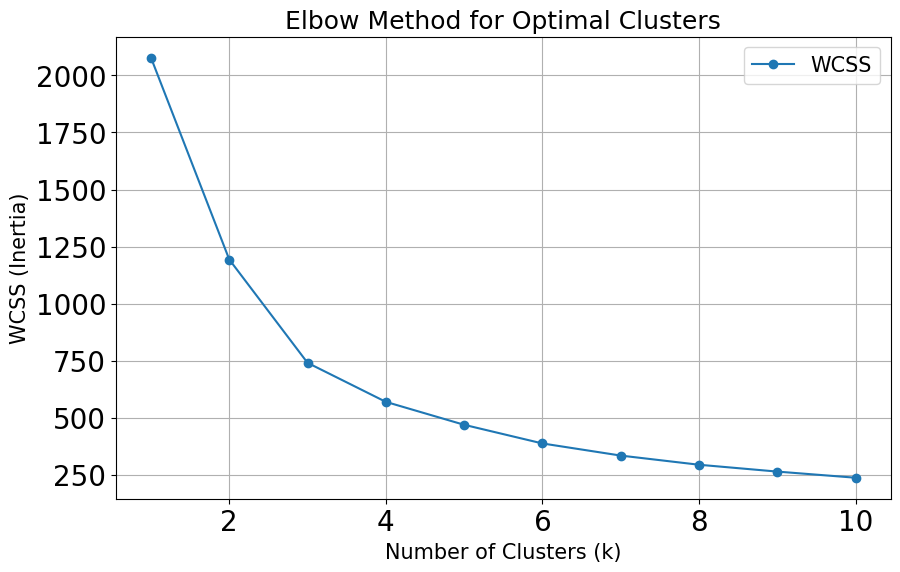

In [45]:
#******************************************PCA******************************************
pca = PCA(n_components=2)  # Reduce to 2 components for easier visualization
df_pca = pca.fit_transform(df_scaled)
#******************************************PCA******************************************





#******************************************FINDING OPTIMAL K******************************************
# Elbow Method to find optimal clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, 
                    random_state=42, 
                    n_init=10, 
                    max_iter=300)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve with larger text
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', label='WCSS')
plt.title("Elbow Method for Optimal Clusters", fontsize=18)  # Larger title
plt.xlabel("Number of Clusters (k)", fontsize=15)  # Larger x-axis label
plt.ylabel("WCSS (Inertia)", fontsize=15)  # Larger y-axis label
plt.xticks(fontsize=20)  # Larger font for x-axis ticks
plt.yticks(fontsize=20)  # Larger font for y-axis ticks
plt.grid()
plt.legend(fontsize=15)  # Add legend with larger font
plt.show()
#******************************************FINDING OPTIMAL K******************************************

In [42]:
#******************************************K AND ITS SCORES (SILHOUETES AND DB)******************************************
# Test a range of cluster numbers for silhouette score and Davies-Bouldin Score
best_silhouette = -1
best_k = None

silhouette_scores_table = []

for n_clusters in range(2, 11):  # Testing clusters from 2 to 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
    cluster_labels = kmeans.fit_predict(df_pca)
    silhouette_avg = silhouette_score(df_pca, cluster_labels)
    db_score = davies_bouldin_score(df_pca, cluster_labels)
    silhouette_scores_table.append({"Number of Clusters": n_clusters, 
                                    "Silhouette Score": round(silhouette_avg, 3), 
                                    "Davies-Bouldin Score": round(db_score, 3)})
    
    if silhouette_avg > best_silhouette:
        best_silhouette = silhouette_avg
        best_k = n_clusters

# Create a DataFrame to display the tabulated silhouette and Davies-Bouldin scores
silhouette_scores_df = pd.DataFrame(silhouette_scores_table)

# Display the tabulated scores in the console
print(silhouette_scores_df)
#******************************************K AND ITS SCORES (SILHOUETES AND DB)******************************************

   Number of Clusters  Silhouette Score  Davies-Bouldin Score
0                   2             0.394                 1.020
1                   3             0.431                 0.809
2                   4             0.383                 0.870
3                   5             0.390                 0.862
4                   6             0.386                 0.860
5                   7             0.394                 0.851
6                   8             0.369                 0.889
7                   9             0.375                 0.857
8                  10             0.386                 0.810


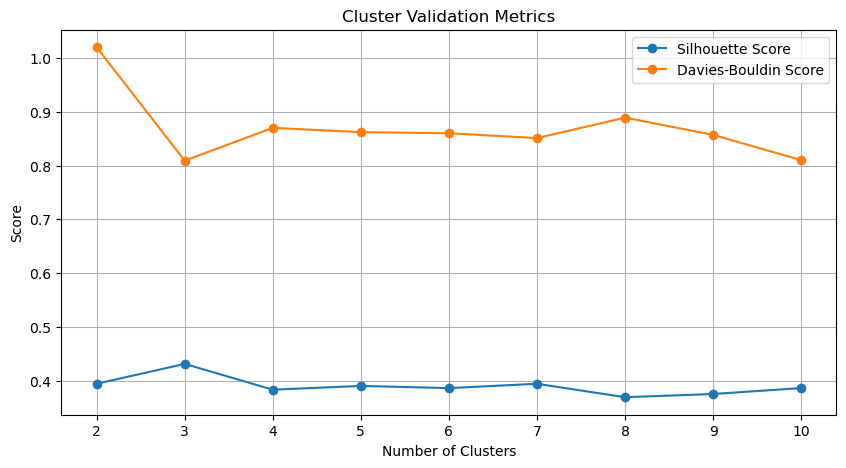

In [43]:
#******************************************VISUALIZE SILHOUTETTE AND DAVIES BOULDIN SCORE******************************************
plt.figure(figsize=(10, 5))
plt.plot(silhouette_scores_df["Number of Clusters"], silhouette_scores_df["Silhouette Score"], marker='o', label="Silhouette Score")
plt.plot(silhouette_scores_df["Number of Clusters"], silhouette_scores_df["Davies-Bouldin Score"], marker='o', label="Davies-Bouldin Score")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Cluster Validation Metrics")
plt.legend()
plt.grid()
plt.show()
#******************************************VISUALIZE SILHOUTETTE AND DAVIES BOULDIN SCORE******************************************

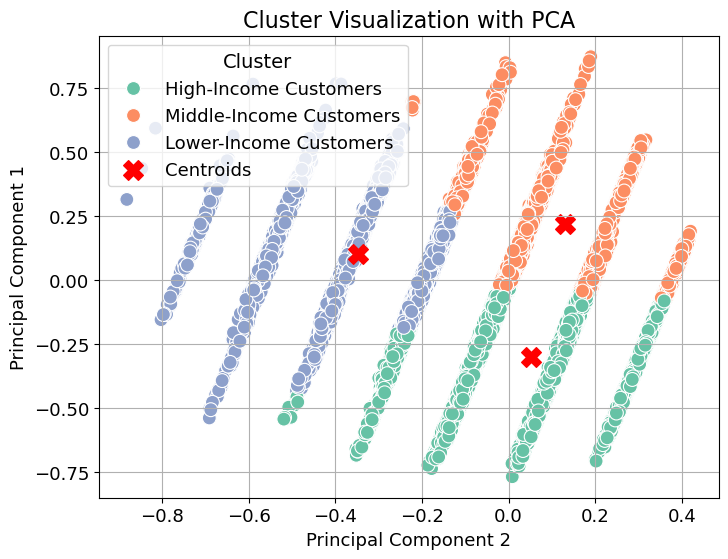

In [49]:
#******************************************K MEANS******************************************
kmeans = KMeans(    n_clusters=3,        # Set the desired number of clusters
                    init="k-means++",    # Initialization method
                    n_init=10,           # Number of initializations (re-runs)
                    max_iter=300,        # Maximum number of iterations
                    random_state=0       # Ensure reproducibility
    )   # Adjust n_clusters as needed
cluster_labels = kmeans.fit_predict(df_pca)
#******************************************K MEANS******************************************





#******************************************SCATTER PLOT******************************************
#PUT COLUMN NAME TO PCA RESULTS (PC1, PC2) AND MAKE NEW DF
df_pca_df = pd.DataFrame(df_pca, columns=["PC1", "PC2"])  # Assuming 2 principal components
df_pca_df['Cluster'] = cluster_labels

#CHANGE CLUSTER NAME
cluster_name_mapping = {
    0: "Lower-Income Customers",
    1: "High-Income Customers",
    2: "Middle-Income Customers",
    3: "Balanced Spenders",
    # Add more mappings if you have more clusters
}
df_pca_df['Cluster'] = df_pca_df['Cluster'].map(cluster_name_mapping)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC2", y="PC1", 
    hue="Cluster", 
    palette="Set2", 
    data=df_pca_df, 
    s=100
)
plt.scatter(kmeans.cluster_centers_[:, 1],
            kmeans.cluster_centers_[:, 0], 
            c='red', 
            marker='X',
            s=200, 
            label='Centroids')      
plt.title("Cluster Visualization with PCA", fontsize=16)
plt.xlabel("Principal Component 2", fontsize=13)
plt.ylabel("Principal Component 1", fontsize=13)
plt.xticks(fontsize=13)  # Larger font size for x-axis tick labels
plt.yticks(fontsize=13)  # Larger font size for y-axis tick labels
plt.legend(title="Cluster", fontsize=13, title_fontsize=14)
plt.grid(True)
plt.show()
#******************************************SCATTER PLOT******************************************